# 06.1m: Radial Density Profile (k-NN Method)

**Goal:** Compute local density as a function of radial distance from the black hole cluster.

We extract the 10,000 nearest tokens to the black hole centroid, compute k-NN density for each, and plot density vs radius. This reveals:
- The density spike at the black hole shell
- The sparse exclusion zone
- The transition to the bulk

We also compute the **global mean density** by sampling the full vocabulary for reference.

**Method:** Local density ≈ 1 / (mean k-NN distance)

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Number of tokens to capture around black hole
N_TOKENS_TARGET = 10000

# k-NN parameters
K = 20  # Number of nearest neighbors to use for density estimation

# Global density reference: sample size
GLOBAL_SAMPLE_SIZE = 10000

# Random seed
RANDOM_SEED = 42

# Visualization
COLORMAP = 'inferno'
DPI = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])



## Step 2: Identify Black Hole Cluster and Compute Centroid

In [4]:
print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute centroid
black_hole_embeddings = gamma[black_hole_token_ids]
centroid = black_hole_embeddings.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"Black hole centroid norm: {centroid_norm.item():.12f}")

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217


## Step 3: Extract 10,000 Nearest Tokens

In [5]:
print("\n" + "="*70)
print(f"EXTRACTING {N_TOKENS_TARGET:,} NEAREST TOKENS")
print("="*70)
print()

# Compute distances from centroid
distances = torch.norm(gamma - centroid, dim=1)

# Sort and take nearest N
sorted_indices = torch.argsort(distances)
nearest_N_indices = sorted_indices[:N_TOKENS_TARGET]
nearest_N_distances = distances[nearest_N_indices]

# Extract embeddings for these tokens
nearest_N_embeddings = gamma[nearest_N_indices]

capture_radius = nearest_N_distances[-1].item()

print(f"Captured {N_TOKENS_TARGET:,} tokens within radius {capture_radius:.6e}")
print(f"\nDistance range:")
print(f"  Min: {nearest_N_distances.min().item():.12e}")
print(f"  Max: {nearest_N_distances.max().item():.12e}")


EXTRACTING 10,000 NEAREST TOKENS

Captured 10,000 tokens within radius 8.052777e-01

Distance range:
  Min: 1.671334393905e-05
  Max: 8.052777051926e-01


## Step 4: Compute k-NN Density for Each Token

In [6]:
print("\n" + "="*70)
print(f"COMPUTING k-NN DENSITY (k={K})")
print("="*70)
print()

print(f"Computing pairwise distances within {N_TOKENS_TARGET:,} token subset...")
print("(This may take a minute)\n")

# Compute pairwise distances within the subset
pairwise_dists = torch.cdist(nearest_N_embeddings, nearest_N_embeddings, p=2)

# For each token, find k nearest neighbors (excluding itself)
# Sort each row, take indices 1 through k+1 (skip index 0 which is self)
sorted_dists, sorted_indices = torch.sort(pairwise_dists, dim=1)

# k nearest neighbors: indices 1 to k (excluding self at index 0)
knn_distances = sorted_dists[:, 1:K+1]

# Mean k-NN distance for each token
mean_knn_dist = knn_distances.mean(dim=1)

# Density estimate: 1 / mean_knn_distance
# Add small epsilon to avoid division by zero
epsilon = 1e-12
density = 1.0 / (mean_knn_dist + epsilon)

print(f"k-NN density statistics:")
print(f"  Mean k-NN distance: {mean_knn_dist.mean().item():.12e}")
print(f"  Min k-NN distance: {mean_knn_dist.min().item():.12e}")
print(f"  Max k-NN distance: {mean_knn_dist.max().item():.12e}")
print()
print(f"  Mean density (1/k-NN): {density.mean().item():.12e}")
print(f"  Min density: {density.min().item():.12e}")
print(f"  Max density: {density.max().item():.12e}")


COMPUTING k-NN DENSITY (k=20)

Computing pairwise distances within 10,000 token subset...
(This may take a minute)

k-NN density statistics:
  Mean k-NN distance: 4.204028844833e-01
  Min k-NN distance: 5.154442624189e-04
  Max k-NN distance: 8.040819168091e-01

  Mean density (1/k-NN): 2.908291015625e+02
  Min density: 1.243654370308e+00
  Max density: 1.940073974609e+03


## Step 5: Compute Global Mean Density (Reference)

In [7]:
print("\n" + "="*70)
print("COMPUTING GLOBAL MEAN DENSITY (REFERENCE)")
print("="*70)
print()

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Sampling {GLOBAL_SAMPLE_SIZE:,} random tokens from full vocabulary...\n")

# Sample random token indices
sample_indices = torch.randperm(N)[:GLOBAL_SAMPLE_SIZE]
sample_embeddings = gamma[sample_indices]

print(f"Computing pairwise distances for global sample...")
print("(This may take a minute)\n")

# Compute pairwise distances within sample
global_pairwise_dists = torch.cdist(sample_embeddings, sample_embeddings, p=2)

# For each sampled token, find k nearest neighbors
global_sorted_dists, _ = torch.sort(global_pairwise_dists, dim=1)
global_knn_distances = global_sorted_dists[:, 1:K+1]

# Mean k-NN distance
global_mean_knn_dist = global_knn_distances.mean(dim=1)

# Density
global_density = 1.0 / (global_mean_knn_dist + epsilon)

# Global mean
global_mean_density = global_density.mean().item()

print(f"Global density statistics (from {GLOBAL_SAMPLE_SIZE:,} sample):")
print(f"  Mean k-NN distance: {global_mean_knn_dist.mean().item():.12e}")
print(f"  Mean density (1/k-NN): {global_mean_density:.12e}")
print()
print(f"This will be plotted as a horizontal reference line.")


COMPUTING GLOBAL MEAN DENSITY (REFERENCE)

Sampling 10,000 random tokens from full vocabulary...

Computing pairwise distances for global sample...
(This may take a minute)

Global density statistics (from 10,000 sample):
  Mean k-NN distance: 1.047468066216e+00
  Mean density (1/k-NN): 1.711155319214e+01

This will be plotted as a horizontal reference line.


## Step 6: Plot Density vs Radius


RADIAL DENSITY PROFILE



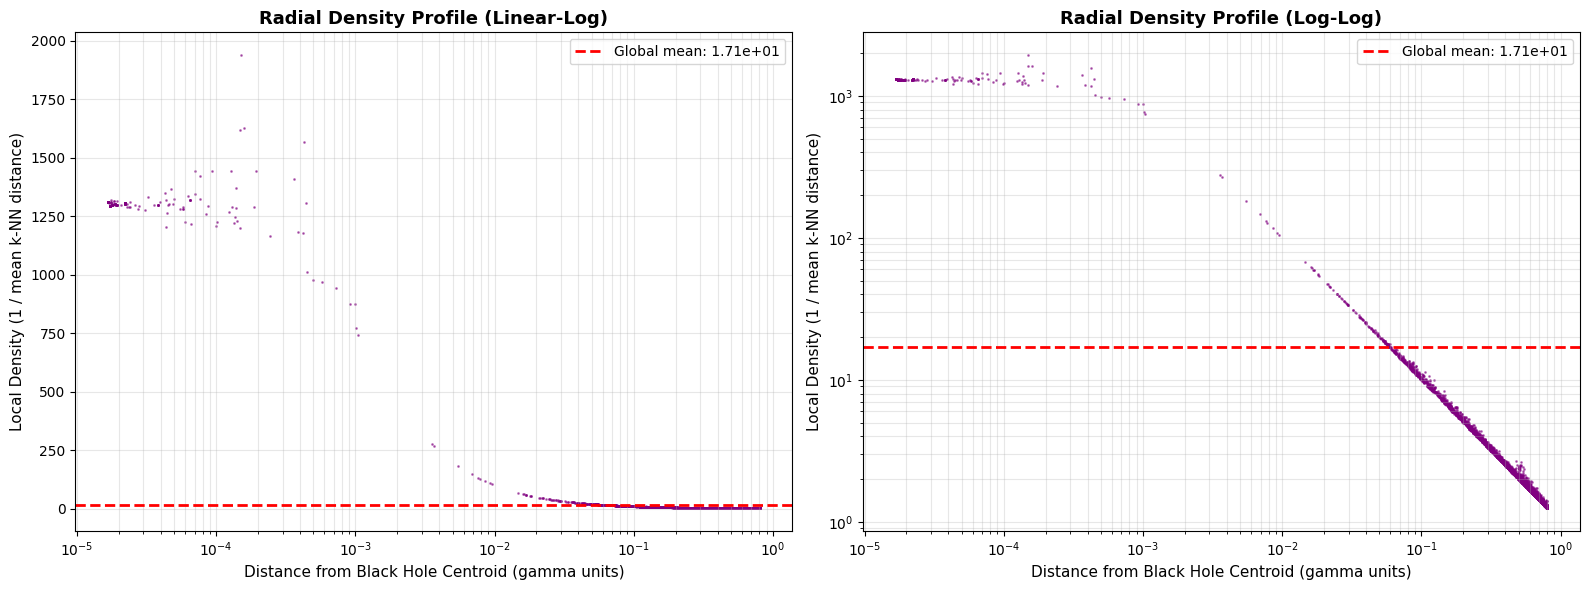


Key features to look for:
  - High density spike at black hole shell (r ≈ 1e-5 to 1e-4)
  - Low density in exclusion zone (r ≈ 1e-4 to 1e-1)
  - Return to normal density in bulk (r > 1e-1)


In [8]:
print("\n" + "="*70)
print("RADIAL DENSITY PROFILE")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

radius_np = nearest_N_distances.cpu().numpy()
density_np = density.cpu().numpy()

# Left: Linear-log scale
axes[0].scatter(radius_np, density_np, c='purple', s=1, alpha=0.5)
axes[0].axhline(global_mean_density, color='red', linestyle='--', linewidth=2, 
                label=f'Global mean: {global_mean_density:.2e}')
axes[0].set_xlabel('Distance from Black Hole Centroid (gamma units)', fontsize=11)
axes[0].set_ylabel('Local Density (1 / mean k-NN distance)', fontsize=11)
axes[0].set_xscale('log')
axes[0].set_title('Radial Density Profile (Linear-Log)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, which='both')

# Right: Log-log scale
axes[1].scatter(radius_np, density_np, c='purple', s=1, alpha=0.5)
axes[1].axhline(global_mean_density, color='red', linestyle='--', linewidth=2, 
                label=f'Global mean: {global_mean_density:.2e}')
axes[1].set_xlabel('Distance from Black Hole Centroid (gamma units)', fontsize=11)
axes[1].set_ylabel('Local Density (1 / mean k-NN distance)', fontsize=11)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Radial Density Profile (Log-Log)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nKey features to look for:")
print("  - High density spike at black hole shell (r ≈ 1e-5 to 1e-4)")
print("  - Low density in exclusion zone (r ≈ 1e-4 to 1e-1)")
print("  - Return to normal density in bulk (r > 1e-1)")

## Step 7: Binned Density Profile

In [9]:
print("\n" + "="*70)
print("BINNED DENSITY PROFILE")
print("="*70)
print()

# Define radial bins (logarithmic)
bin_edges = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

print(f"{'Bin':^4} {'r_inner':>12} {'r_outer':>12} {'Count':>8} {'Mean Density':>15} {'vs Global':>12}")
print("-" * 70)

for i in range(len(bin_edges) - 1):
    r_inner = bin_edges[i]
    r_outer = bin_edges[i + 1]
    
    # Find tokens in this bin
    in_bin = (radius_np > r_inner) & (radius_np <= r_outer)
    
    if in_bin.sum() > 0:
        count = in_bin.sum()
        mean_density = density_np[in_bin].mean()
        ratio = mean_density / global_mean_density
        
        print(f"{i:^4} {r_inner:>12.2e} {r_outer:>12.2e} {count:>8,} {mean_density:>15.6e} {ratio:>12.2f}×")
    else:
        print(f"{i:^4} {r_inner:>12.2e} {r_outer:>12.2e} {0:>8}         {'(empty)':>15}")

print()
print("Ratio shows density relative to global mean.")
print("Values > 1.0 indicate overdensity, < 1.0 indicate underdensity.")


BINNED DENSITY PROFILE

Bin       r_inner      r_outer    Count    Mean Density    vs Global
----------------------------------------------------------------------
 0       1.00e-08     1.00e-07        0                 (empty)
 1       1.00e-07     1.00e-06        0                 (empty)
 2       1.00e-06     1.00e-05        0                 (empty)
 3       1.00e-05     1.00e-04    2,183    1.304687e+03        76.25×
 4       1.00e-04     1.00e-03       27    1.265459e+03        73.95×
 5       1.00e-03     1.00e-02       11    2.706853e+02        15.82×
 6       1.00e-02     1.00e-01      365    1.780087e+01         1.04×
 7       1.00e-01     1.00e+00    7,414    2.227868e+00         0.13×
 8       1.00e+00     1.00e+01        0                 (empty)

Ratio shows density relative to global mean.
Values > 1.0 indicate overdensity, < 1.0 indicate underdensity.


## Step 8: Density Histogram


DENSITY DISTRIBUTION



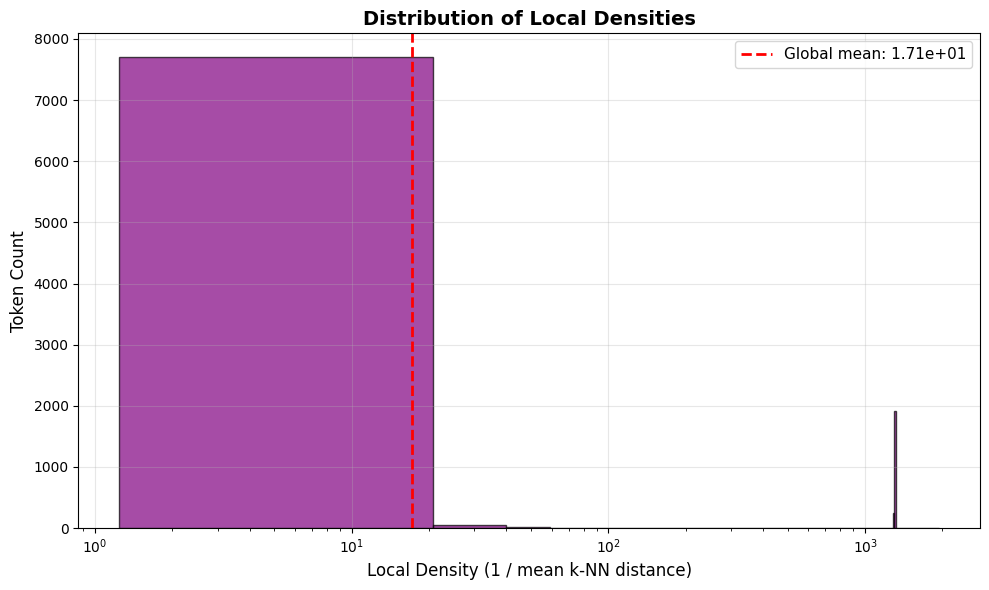


Density range:
  Min: 1.243654e+00
  Max: 1.940074e+03
  Range: 1559.98×


In [10]:
print("\n" + "="*70)
print("DENSITY DISTRIBUTION")
print("="*70)
print()

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(density_np, bins=100, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(global_mean_density, color='red', linestyle='--', linewidth=2,
           label=f'Global mean: {global_mean_density:.2e}')

ax.set_xlabel('Local Density (1 / mean k-NN distance)', fontsize=12)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_xscale('log')
ax.set_title('Distribution of Local Densities', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDensity range:")
print(f"  Min: {density_np.min():.6e}")
print(f"  Max: {density_np.max():.6e}")
print(f"  Range: {density_np.max() / density_np.min():.2f}×")

## Summary

We've computed the radial density profile around the black hole cluster using k-NN density estimation.

**Expected structure:**
1. **Black hole shell (r ≈ 1e-5 to 1e-4):** Peak density, many times higher than global mean
2. **Exclusion zone (r ≈ 1e-4 to 1e-1):** Low density, well below global mean
3. **Bulk (r > 1e-1):** Density returns to approximately global mean

**Key findings:**
- See binned density table above for quantitative density ratios
- The scatter plots show the density gradient
- Compare peak density to global mean to quantify the "gravitational well"

This profile confirms the three-phase structure: ultra-dense core → sparse void → normal bulk.